In [1]:
from IPython.core.display import HTML, display

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from cmocean import cm as cmo

from pymc_utils import PyMCModel

In [2]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [3]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [264]:
def bayes_nn_model_l1_h(X, y_obs, n_hidden=None, lklhd_name='likelihood', include_bias=False,
                       parameterize_elu=False):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    
    with pm.Model() as model:
        
        if parameterize_elu:
            alpha_elu = pm.HalfNormal('alpha_elu', sd=1)
        else:
            alpha_elu = 1
        elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden))
        elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden + 1))
        init_1 = np.random.randn(num_feats, n_hidden) * elu_init_scale1
        init_2 = np.random.randn(n_hidden,) * elu_init_scale2
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=2.5)
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=2.5)
        w_i_1 = pm.Normal('wts_i_1', mu=0, sd=hyp_wi1_sd, shape=(num_feats, n_hidden), 
                      testval=init_1)
        w_1_o = pm.Normal('wts_1_out', mu=0, sd=hyp_w1o_sd, shape=(n_hidden,),
                      testval=init_2)
        #w_i_1 = pm.Laplace('wts_i_1', mu=0, b=hyp_wi1_sd, shape=(num_feats, n_hidden),)
        #w_1_o = pm.Laplace('wts_1_out', mu=0, b=hyp_w1o_sd, shape=(n_hidden,))
        if include_bias:
            init_b1 = np.random.randn(n_hidden,)
            init_b2 = np.random.randn()
            b1 = pm.Normal('bias_1', mu=0, sd=1, shape=(n_hidden,))
            b2 = pm.Normal('bias_out', mu=0, sd=1, shape=(1,))
        else:
            b1=b2=0
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.elu(tt.dot(X, w_i_1), alpha=alpha_elu) + b1)
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b2)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model


def bayes_nn_l2_h(X, y_obs, n_hidden1, n_hidden2, lklhd_name='likelihood', include_bias=False):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))
    with pm.Model() as model:
        
        init_1 = np.random.randn(num_feats, n_hidden1) * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2) * elu_init_scale2
        init_3 = np.random.randn(n_hidden2,)
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn()
            b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Normal('bias_layer3', mu=0, sd=1, testval=init_b3)
        else:
            b1 = b2 = b3 = 0
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1)
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1)
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Normal('wts_2_out', mu=0, sd=hyper_w3_sd, shape=(n_hidden2,),
                      testval=init_3)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.elu(tt.dot(X, w1)) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.elu(tt.dot(lyr1_act, w2)) + b2)
        out_act = pm.Deterministic('layer3_act', tt.dot(lyr2_act, w3) + b3)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model


def bayes_nn_l3_h(X, y_obs, n_hidden1, n_hidden2, n_hidden3, lklhd_name='likelihood', include_bias=False):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden1))
    elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden1 + n_hidden2))
    elu_init_scale3 = np.sqrt(2) * np.sqrt(2 / (n_hidden2 + n_hidden3))
    elu_init_scale4 = np.sqrt(2) * np.sqrt(2 / (n_hidden3 + 1))
    with pm.Model() as model:
        
        init_1 = np.random.randn(num_feats, n_hidden1) * elu_init_scale1
        init_2 = np.random.randn(n_hidden1, n_hidden2) * elu_init_scale2
        init_3 = np.random.randn(n_hidden2, n_hidden3) * elu_init_scale3
        init_4 = np.random.randn(n_hidden3,) * elu_init_scale4
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn(n_hidden3,)
            init_b4 = np.random.randn()
            b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Normal('bias_layer3', mu=0, sd=1, shape=(n_hidden3,),
                           testval=init_b3)
            b4 = pm.Normal('bias_layer4', mu=0, sd=1, testval=init_b4)
            
        else:
            b1 = b2 = b3 = b4 = 0
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1)
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1)
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        hyper_w4_sd = pm.HalfCauchy('hyper_w4_sd', beta=1)
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Normal('wts_2_3', mu=0, sd=hyper_w3_sd, shape=(n_hidden2, n_hidden3),
                      testval=init_3)
        w4 = pm.Normal('wts_3_out', mu=0, sd=hyper_w4_sd, shape=(n_hidden3,))
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.elu(tt.dot(X, w1)) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.elu(tt.dot(lyr1_act, w2)) + b2)
        lyr3_act = pm.Deterministic('layer3_act', tt.nnet.elu(tt.dot(lyr2_act, w3)) + b3)
        out_act = pm.Deterministic('out_act', tt.dot(lyr3_act, w4) + b4)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [63]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [275]:
dsi = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_PolyFeatures_SWF.pkl')

In [277]:
dsi['log10_aphi411'] = np.log10(dsi.aphy411)

In [278]:
dsi.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [68]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [280]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC6_s'
predictor = 'aphy411'
X_s = ds.dropna().loc[:, :feat_end_ni]
Xi_s = dsi.dropna().loc[:, :]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().log10_aphy411
yi = dsi.dropna().log10_aphi411

In [83]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

In [281]:
Xi_s_train, Xi_s_test, yi_train, yi_test = train_test_split(Xi_s, yi, test_size=0.1,
                                                           random_state=42)

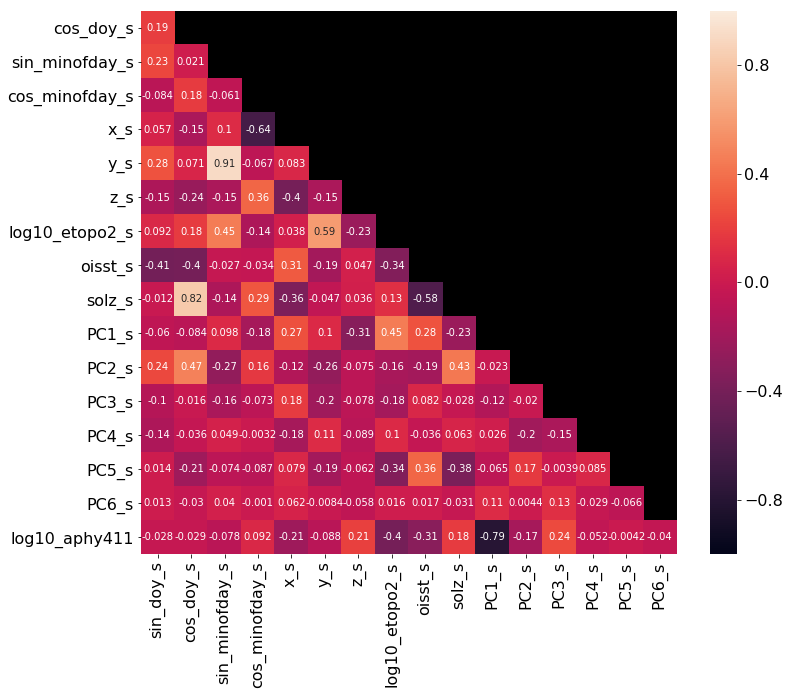

In [84]:
Xy_train = pd.concat((X_s_train, y_train), axis=1)
f, ax = pl.subplots(figsize=(12, 10))
heatmap(Xy_train.corr().iloc[1:,:-1],vmin=-1, vmax=1, mask=np.triu(np.ones([Xy_train.shape[1]-1] * 2),k=1), ax=ax,
        annot=True, annot_kws={'fontsize': 10})
ax.set_facecolor('k')

### Fitting w/ All Features

#### Single Layer BNN

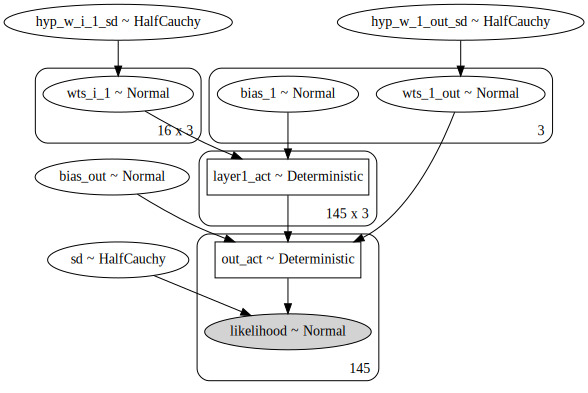

In [175]:
X_shared = shared(X_s_train.values)
bnn_l1 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train, n_hidden=3, include_bias=True)
bnn_l1.show_model()

In [176]:
bnn_l1.fit_ADVI()

Average Loss = 15.057: 100%|██████████| 100000/100000 [00:48<00:00, 2072.32it/s]
Finished [100%]: Average Loss = 15.032


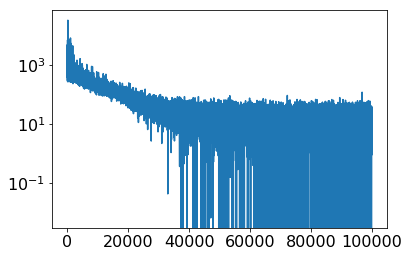

In [177]:
pl.semilogy(bnn_l1.approx_fit.hist)

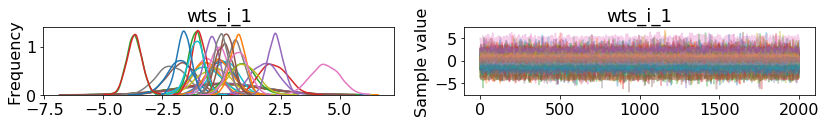

In [178]:
bnn_l1.evaluate_fit(['wts_i_1']);

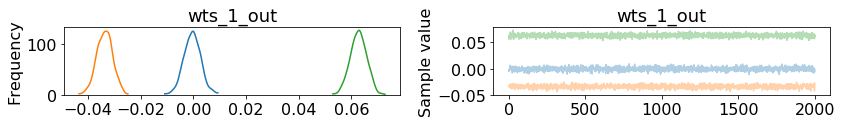

In [179]:
bnn_l1.evaluate_fit(['wts_1_out']);

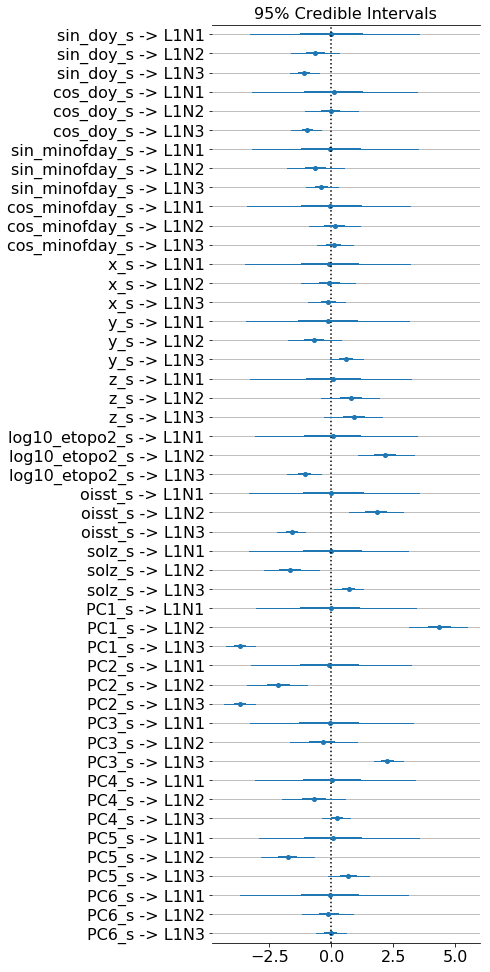

In [258]:
labels = ['%s -> L1N%d' %(li, ni) for li in lbls_X_s for ni in range(1, 4)]
bnn_l1.show_forest(['wts_i_1'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(15);

100%|██████████| 2000/2000 [00:01<00:00, 1374.35it/s]


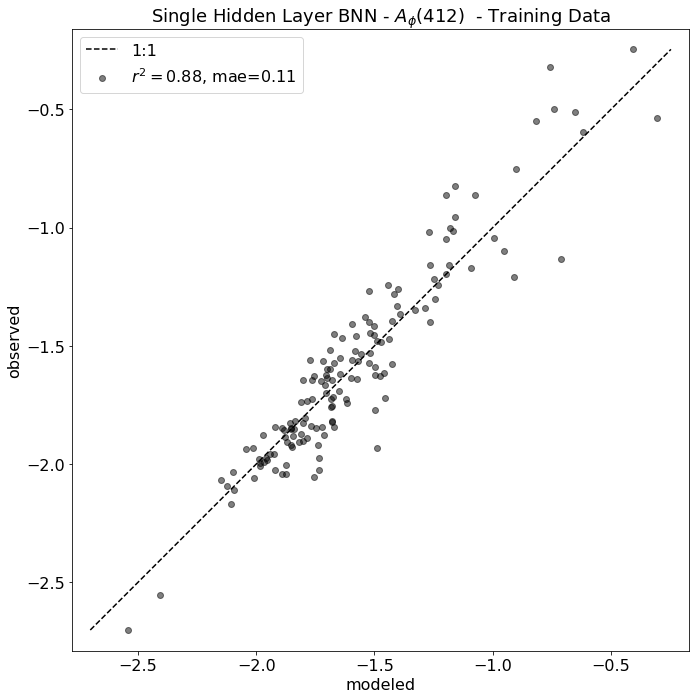

In [181]:
ppc_train_l1 = bnn_l1.predict(X_shared, likelihood_name='likelihood')

bnn_l1.plot_model_fits(y_train, ppc_train_l1, loss_metric='mae',
                       title='Single Hidden Layer BNN - $A_{\phi}(412)$  - Training Data');

100%|██████████| 2000/2000 [00:01<00:00, 1108.30it/s]


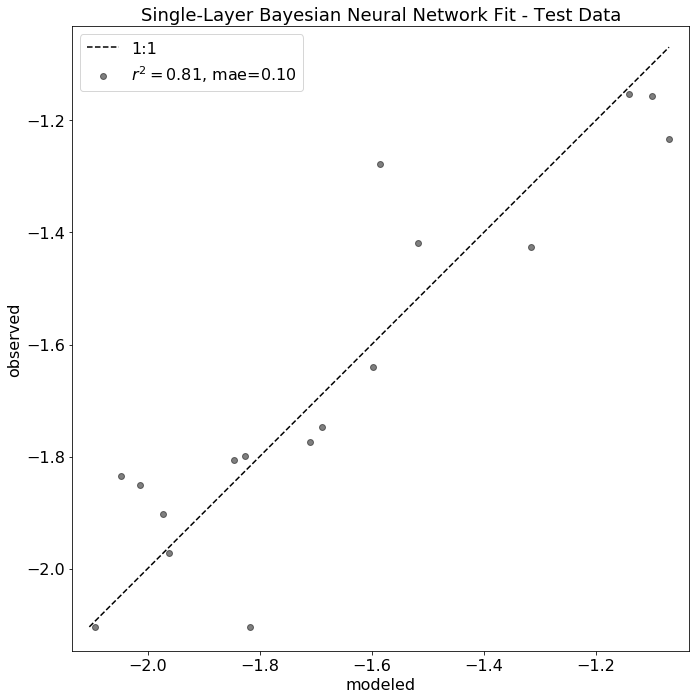

In [182]:
X_shared.set_value(X_s_test.values)
ppc_test_l1 = bnn_l1.predict(X_shared, likelihood_name='likelihood')
bnn_l1.plot_model_fits(y_test, ppc_test_l1, loss_metric='mae',
                       title='Single-Layer Bayesian Neural Network Fit - Test Data');

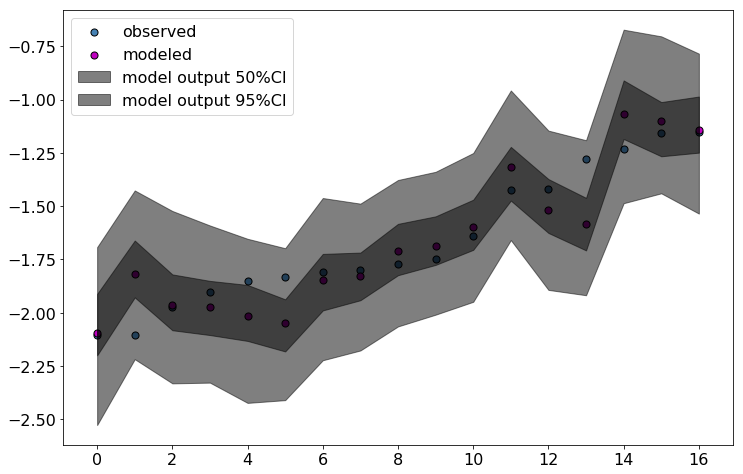

In [183]:
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
ppc_test = ppc_test_l1
lik_mean =ppc_test.mean(axis=0)
lik_hpd = pm.hpd(ppc_test)
lik_hpd_05 = pm.hpd(ppc_test, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
f_fit2.savefig('./figJar/bayesNet/bNN_L1_nobias.png', dpi=300, format='png')

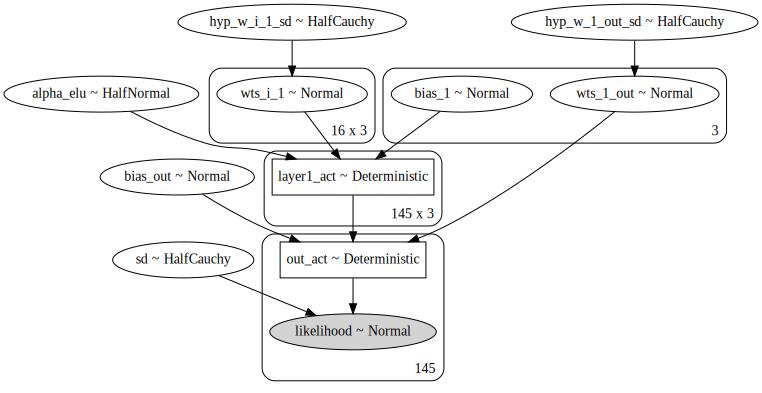

In [265]:
X_shared = shared(X_s_train.values)
bnn_l1b = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train, n_hidden=3, include_bias=True, parameterize_elu=True)
bnn_l1b.show_model()

In [266]:
bnn_l1b.fit_ADVI(n_iter=50000)

Average Loss = 16.826: 100%|██████████| 50000/50000 [00:29<00:00, 1683.41it/s]
Finished [100%]: Average Loss = 16.815


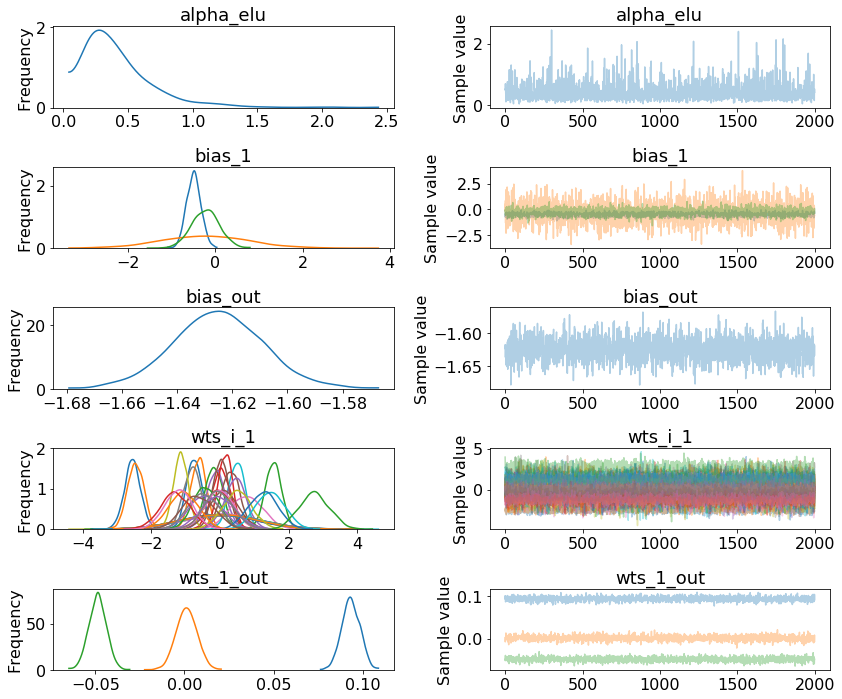

In [274]:
bnn_l1b.evaluate_fit(['alpha_elu', 'bias_1', 'bias_out', 'wts_i_1', 'wts_1_out']);

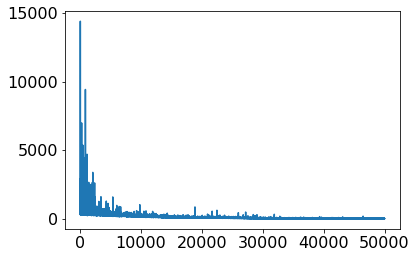

In [267]:
pl.plot(bnn_l1b.approx_fit.hist);

100%|██████████| 2000/2000 [00:01<00:00, 1002.20it/s]


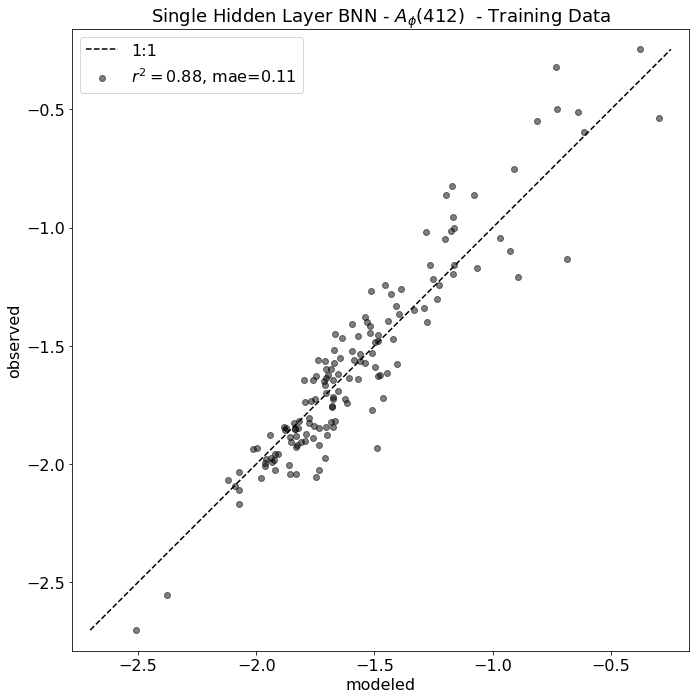

In [268]:
ppc_train_l1b = bnn_l1b.predict(X_shared, likelihood_name='likelihood')

bnn_l1b.plot_model_fits(y_train, ppc_train_l1b, loss_metric='mae',
                       title='Single Hidden Layer BNN - $A_{\phi}(412)$  - Training Data');

100%|██████████| 2000/2000 [00:02<00:00, 992.82it/s] 


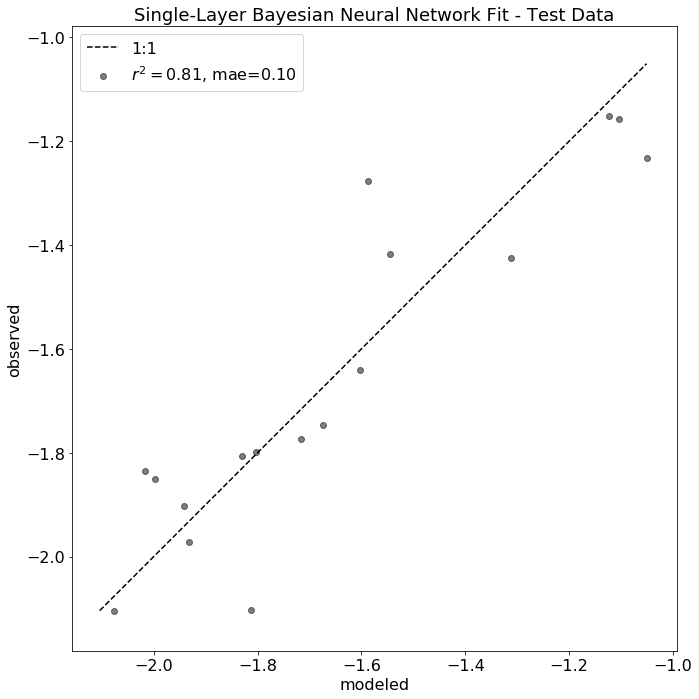

In [269]:
X_shared.set_value(X_s_test.values)
ppc_test_l1b = bnn_l1b.predict(X_shared, likelihood_name='likelihood')
bnn_l1b.plot_model_fits(y_test, ppc_test_l1b, loss_metric='mae',
                       title='Single-Layer Bayesian Neural Network Fit - Test Data');

#### Double Layer BNN

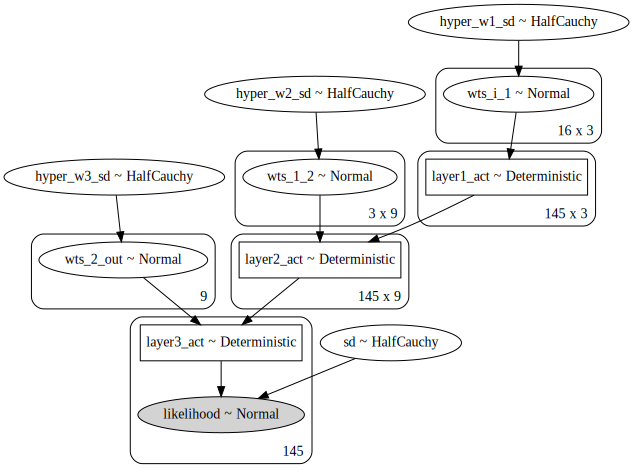

In [252]:
X_shared = shared(X_s_train.values)
bnn_l2 = PyMCModel(bayes_nn_l2_h, X_shared, y_train, n_hidden1=3, n_hidden2=9, include_bias=True)
bnn_l2.show_model()

In [253]:
bnn_l2.fit_ADVI(n_iter=40000)

Average Loss = 261.99: 100%|██████████| 40000/40000 [00:22<00:00, 1761.62it/s]
Finished [100%]: Average Loss = 261.95


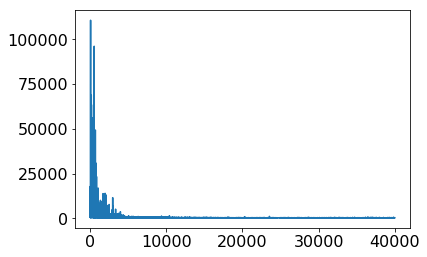

In [254]:
pl.plot(bnn_l2.approx_fit.hist)

100%|██████████| 2000/2000 [00:01<00:00, 1186.95it/s]


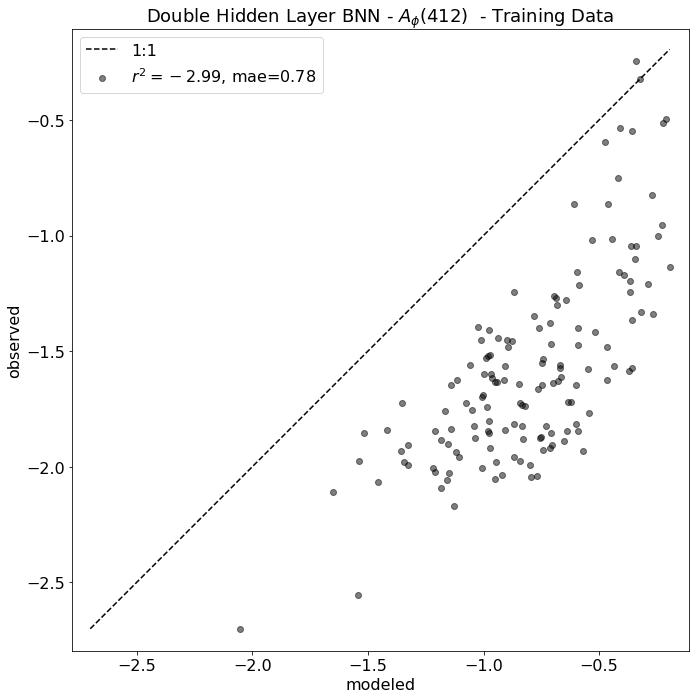

In [255]:
ppc_train_l2 = bnn_l2.predict(X_shared, likelihood_name='likelihood')

bnn_l2.plot_model_fits(y_train, ppc_train_l2, loss_metric='mae',
                       title='Double Hidden Layer BNN - $A_{\phi}(412)$  - Training Data');

### Fitting w/ PCs only

In [184]:
# extract pc columns
X_s_train_pc = X_s_train.filter(regex='PC', axis=1)
X_s_test_pc = X_s_test.filter(regex='PC', axis=1)

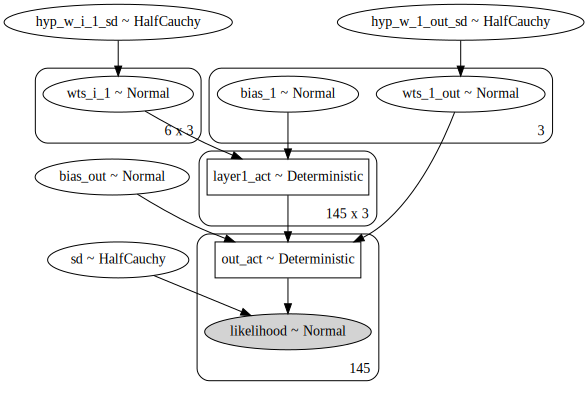

In [185]:
X_shared_pc = shared(X_s_train_pc.values)
bnn_l1_pc = PyMCModel(bayes_nn_model_l1_h, X_shared_pc, y_train, n_hidden=3, include_bias=True)
bnn_l1_pc.show_model()

In [186]:
bnn_l1_pc.fit_ADVI()

Average Loss = 0.4348: 100%|██████████| 100000/100000 [00:46<00:00, 2140.91it/s]
Finished [100%]: Average Loss = 0.45109


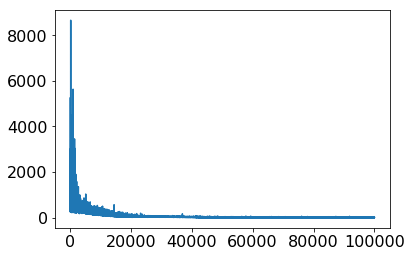

In [189]:
pl.plot(bnn_l1_pc.approx_fit.hist);

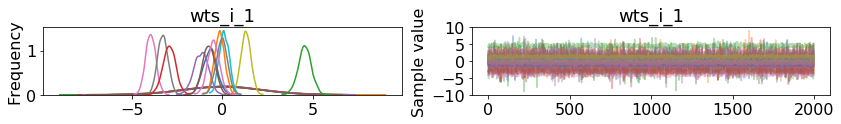

In [190]:
bnn_l1_pc.evaluate_fit(['wts_i_1']);

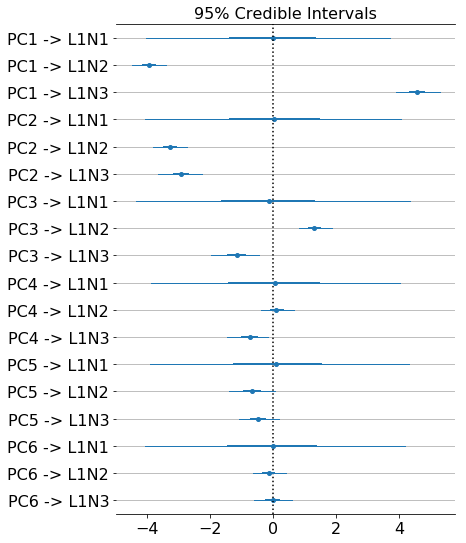

In [193]:
labels = ['PC%d -> L1N%d' %(i, ni) for i in range(1, 7) for ni in range(1, 4)]
bnn_l1_pc.show_forest(['wts_i_1'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(8);

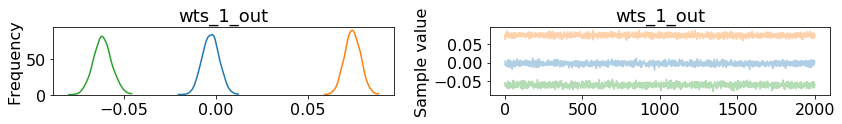

In [194]:
bnn_l1_pc.evaluate_fit(['wts_1_out']);

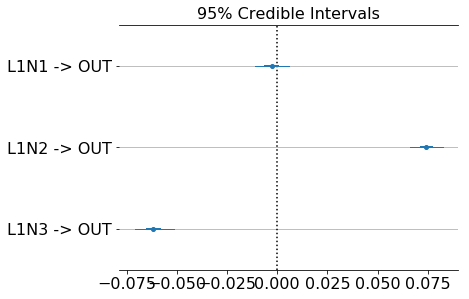

In [196]:
labels = ['L1N%d -> OUT' %i for i in range(1, 4) ]
bnn_l1_pc.show_forest(['wts_1_out'], feat_labels=labels);
#f = pl.gcf()
#f.set_figheight(12);

100%|██████████| 2000/2000 [00:01<00:00, 1377.85it/s]


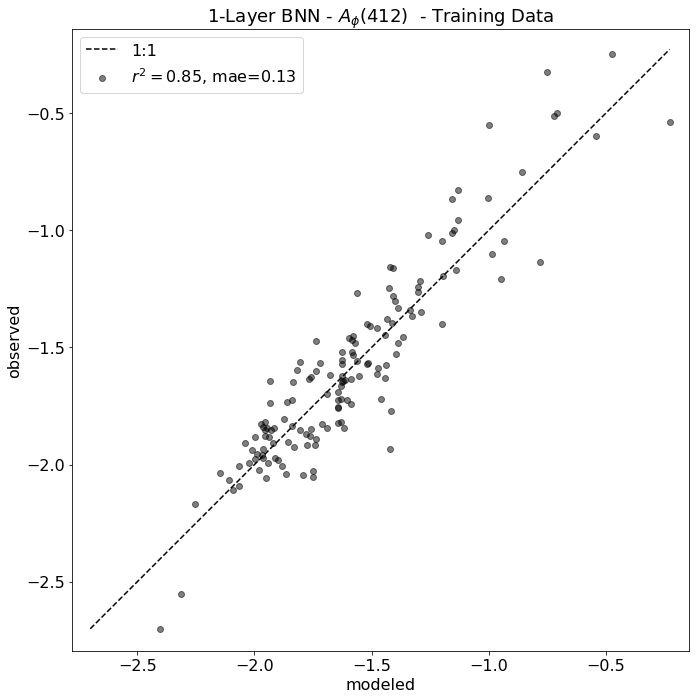

In [197]:
ppc_train_l1_pc = bnn_l1_pc.predict(X_shared_pc, likelihood_name='likelihood')

bnn_l1_pc.plot_model_fits(y_train, ppc_train_l1_pc, loss_metric='mae',
                       title='1-Layer BNN - $A_{\phi}(412)$  - Training Data');

100%|██████████| 2000/2000 [00:01<00:00, 1094.36it/s]


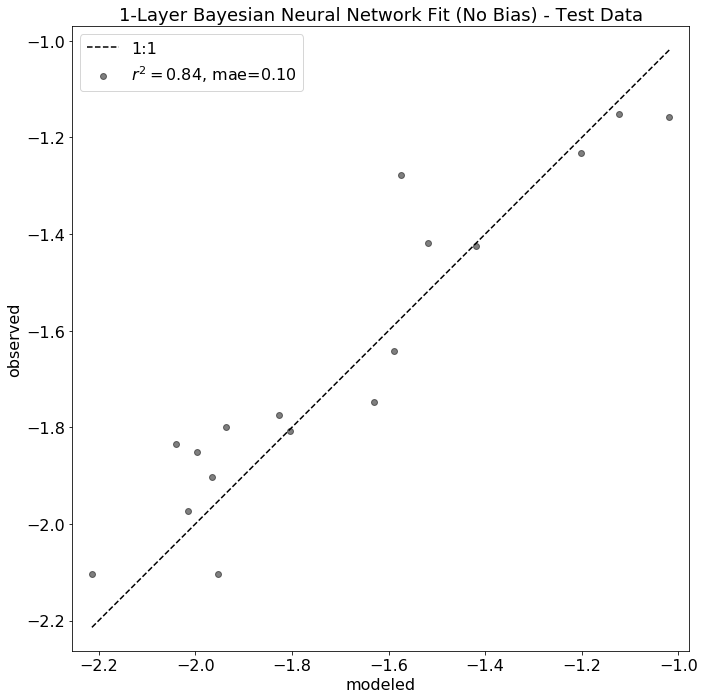

In [198]:
X_shared_pc.set_value(X_s_test.filter(regex='PC').values)
ppc_test_l1_pc = bnn_l1_pc.predict(X_shared_pc, likelihood_name='likelihood')
bnn_l1_pc.plot_model_fits(y_test, ppc_test_l1_pc, loss_metric='mae',
                       title='1-Layer Bayesian Neural Network Fit (No Bias) - Test Data');

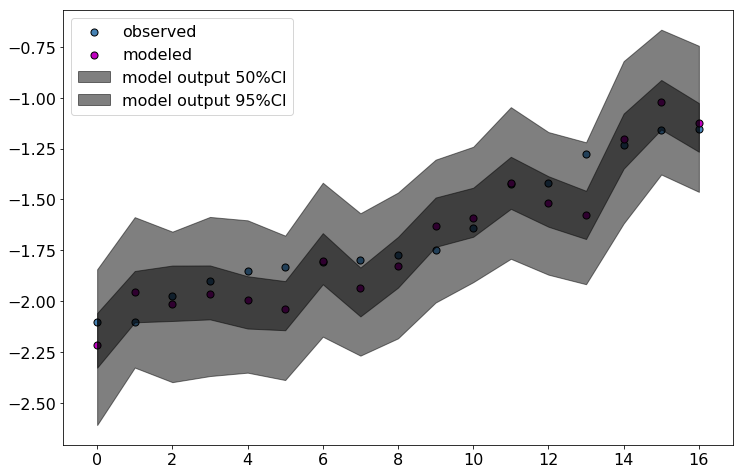

In [199]:
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
ppc_test = ppc_test_l1_pc
lik_mean =ppc_test.mean(axis=0)
lik_hpd = pm.hpd(ppc_test)
lik_hpd_05 = pm.hpd(ppc_test, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
#f_fit2.savefig('./figJar/bayesNet/bNN_L1APHI.png', dpi=300, format='png')

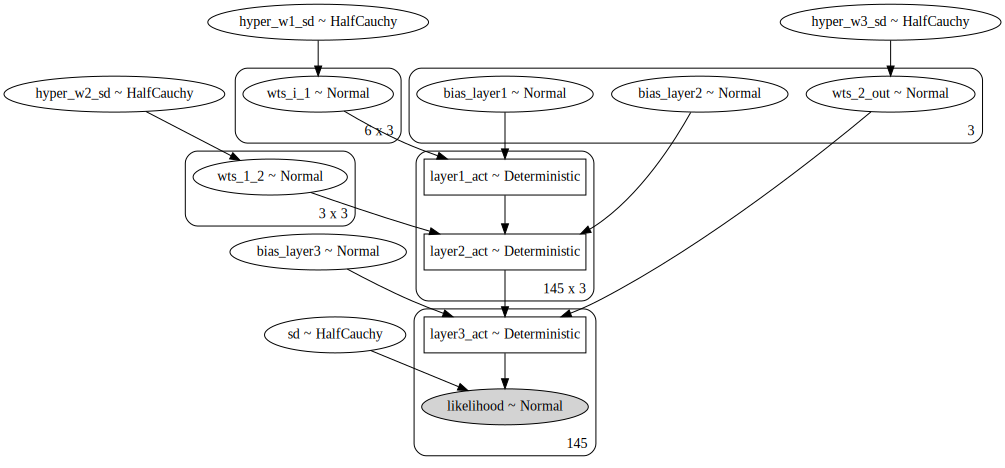

In [200]:
X_pc_shared = shared(X_s_train_pc.values)
bnn_l2h_pc = PyMCModel(bayes_nn_l2_h, X_pc_shared, y_train, model_name='bnnl2_aphi',
                         n_hidden1=3, n_hidden2=3, include_bias=True)
bnn_l2h_pc.show_model()

In [201]:
bnn_l2h_pc.fit_ADVI(n_iter=200000)

Average Loss = 9.7439: 100%|██████████| 500000/500000 [04:28<00:00, 1862.67it/s]
Finished [100%]: Average Loss = 9.7698


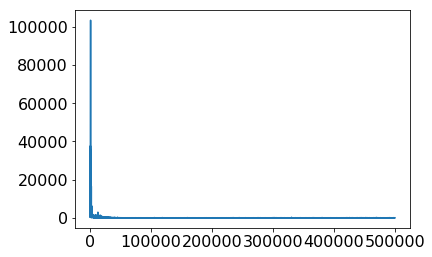

In [204]:
pl.plot(bnn_l2h_pc.approx_fit.hist);

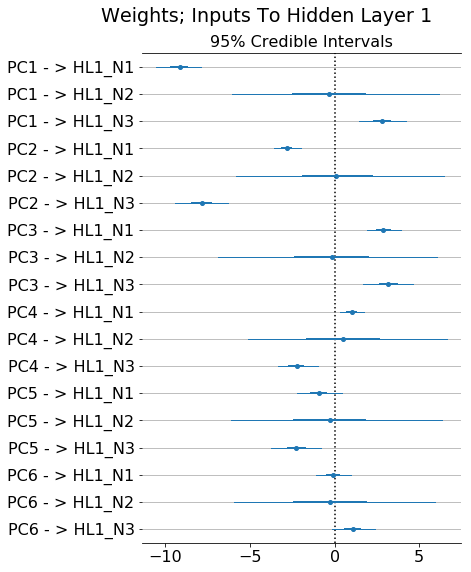

In [217]:
labels = ['PC%d - > HL1_N%d' %(l1n, l2n) for l1n in range(1, 7) for l2n in range(1, 4)]
bnn_l2h_pc.show_forest(['wts_i_1'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(8)
f.suptitle('Weights; Inputs To Hidden Layer 1');

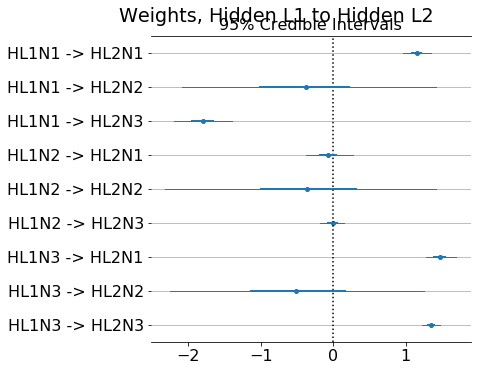

In [208]:
labels = ['HL1N%d -> HL2N%d' %(hl1n, hl2n) for hl1n in range(1, 4) for hl2n in range(1, 4)]

bnn_l2h_pc.show_forest(['wts_1_2'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(5)
f.suptitle('Weights, Hidden L1 to Hidden L2');

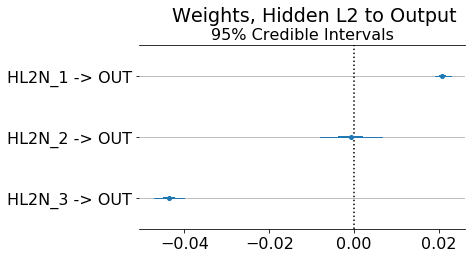

In [209]:
labels = ['HL2N_%d -> OUT' %ni for ni in range(1, 4)]
bnn_l2h_pc.show_forest(['wts_2_out'], feat_labels=labels);
f = pl.gcf()
#ax = pl.gca()
#ax.set_xlim(ax.get_xlim()[0]*2, 0.005)
f.set_figheight(3)
f.suptitle('Weights, Hidden L2 to Output', x=0.6, y=1.08);

100%|██████████| 2000/2000 [00:01<00:00, 1073.83it/s]


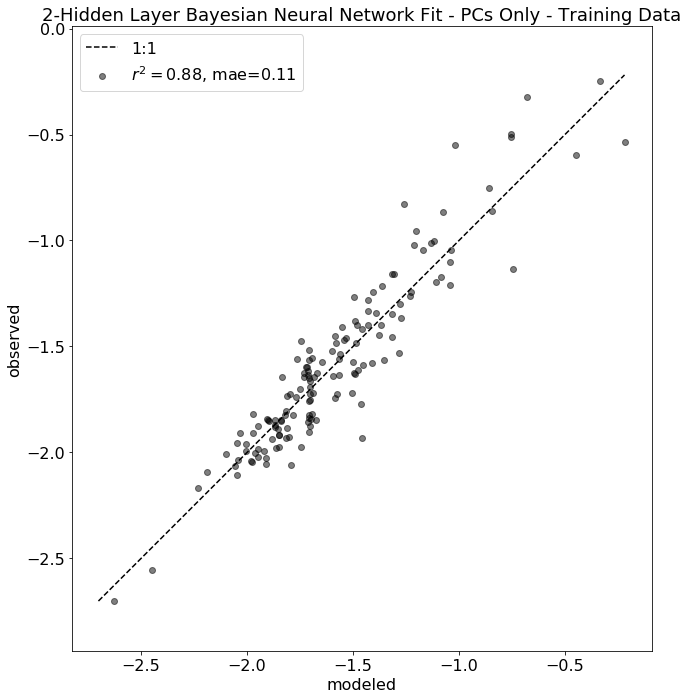

In [210]:
ppc_train_l2h = bnn_l2h_pc.predict(X_pc_shared, likelihood_name='likelihood')

bnn_l2h_pc.plot_model_fits(y_train, ppc_train_l2h, loss_metric='mae',
                       title='2-Hidden Layer Bayesian Neural Network Fit - PCs Only - Training Data'); 

100%|██████████| 2000/2000 [00:02<00:00, 829.54it/s]


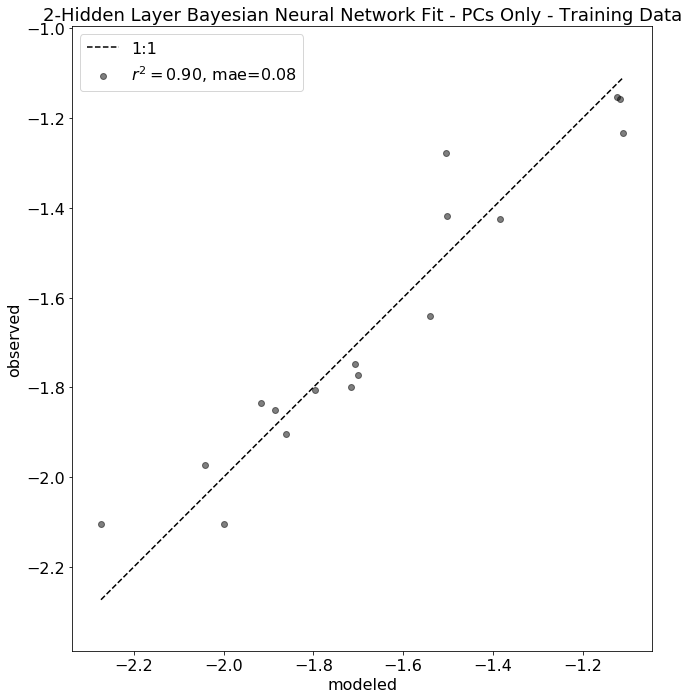

In [211]:
X_pc_shared.set_value(X_s_test_pc)
ppc_test_l2h = bnn_l2h_pc.predict(X_pc_shared, likelihood_name='likelihood')

bnn_l2h_pc.plot_model_fits(y_test, ppc_test_l2h, loss_metric='mae',
                       title='2-Hidden Layer Bayesian Neural Network Fit - PCs Only - Training Data'); 

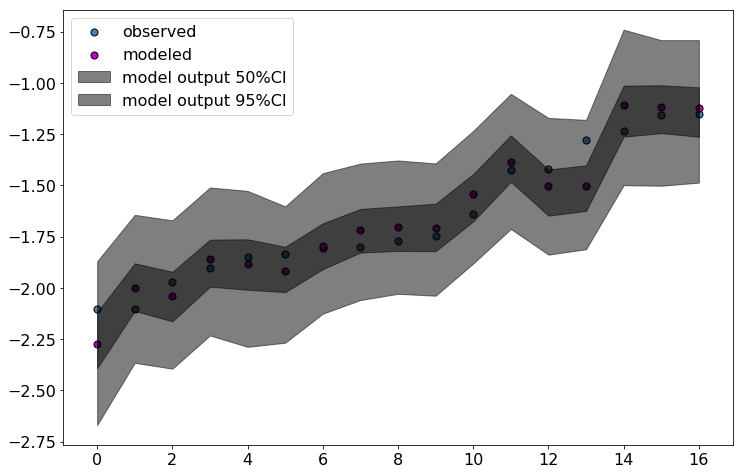

In [212]:
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
lik_mean =ppc_test_l2h.mean(axis=0)
lik_hpd = pm.hpd(ppc_test_l2h)
lik_hpd_05 = pm.hpd(ppc_test_l2h, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
f_fit2.savefig('./figJar/bayesNet/bNN_L2.png', dpi=300, format='png')

#### 3 hidden layers

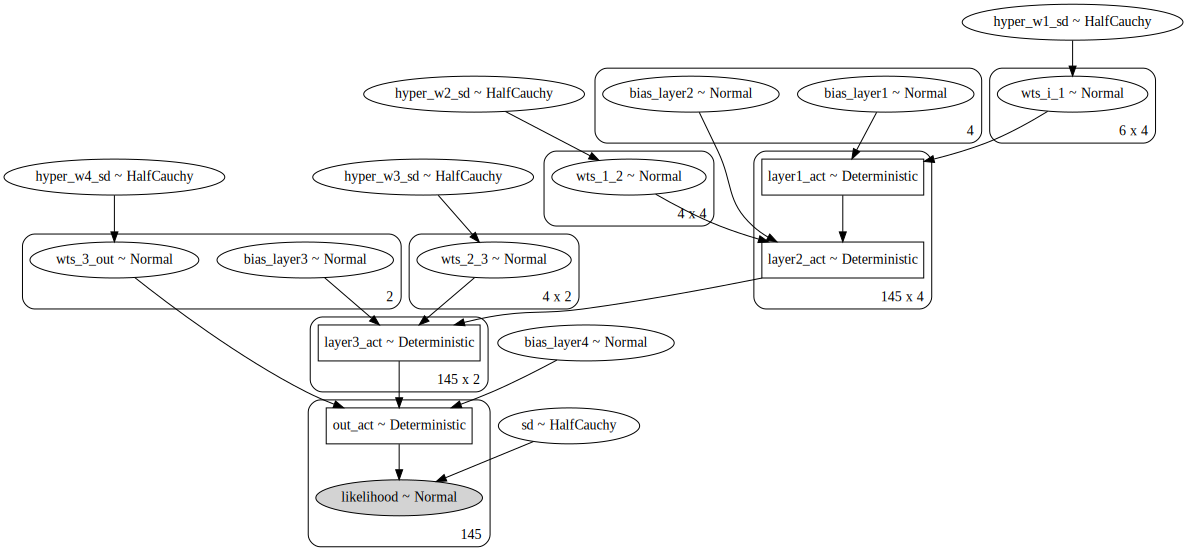

In [221]:
X_pc_shared = shared(X_s_train_pc.values)
bnn_l3h_pc = PyMCModel(bayes_nn_l3_h, X_pc_shared, y_train, model_name='bnnl3_aphi',
                         n_hidden1=4, n_hidden2=4, n_hidden3=2, include_bias=True)
bnn_l3h_pc.show_model()

In [222]:
bnn_l3h_pc.fit_ADVI()

Average Loss = 99.601: 100%|██████████| 100000/100000 [01:01<00:00, 1628.62it/s]
Finished [100%]: Average Loss = 99.601


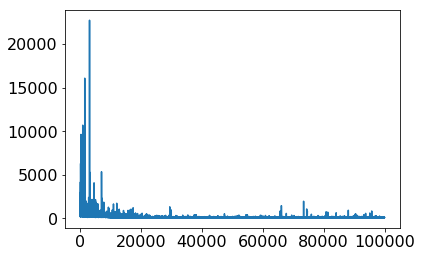

In [223]:
pl.plot(bnn_l3h_pc.approx_fit.hist);

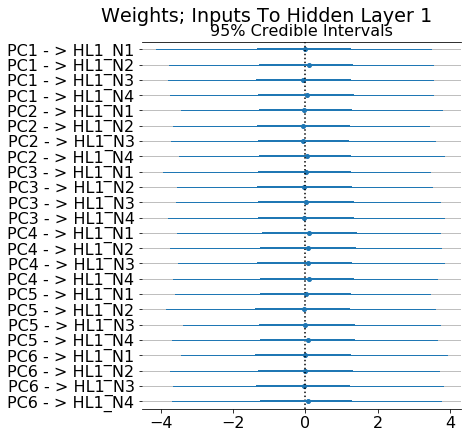

In [225]:
labels = ['PC%d - > HL1_N%d' %(l1n, l2n) for l1n in range(1, 7) for l2n in range(1, 5)]
bnn_l3h_pc.show_forest(['wts_i_1'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(6)
f.suptitle('Weights; Inputs To Hidden Layer 1');

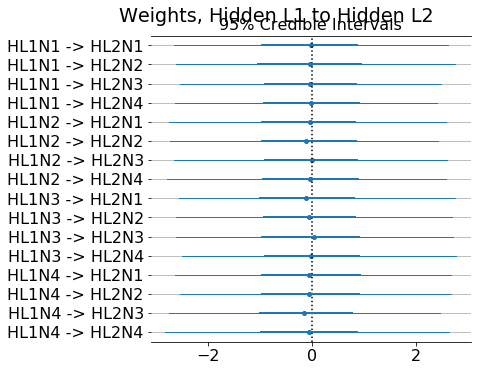

In [226]:
labels = ['HL1N%d -> HL2N%d' %(hl1n, hl2n) for hl1n in range(1, 5) for hl2n in range(1, 5)]

bnn_l3h_pc.show_forest(['wts_1_2'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(5)
f.suptitle('Weights, Hidden L1 to Hidden L2');

100%|██████████| 2000/2000 [00:02<00:00, 757.97it/s]


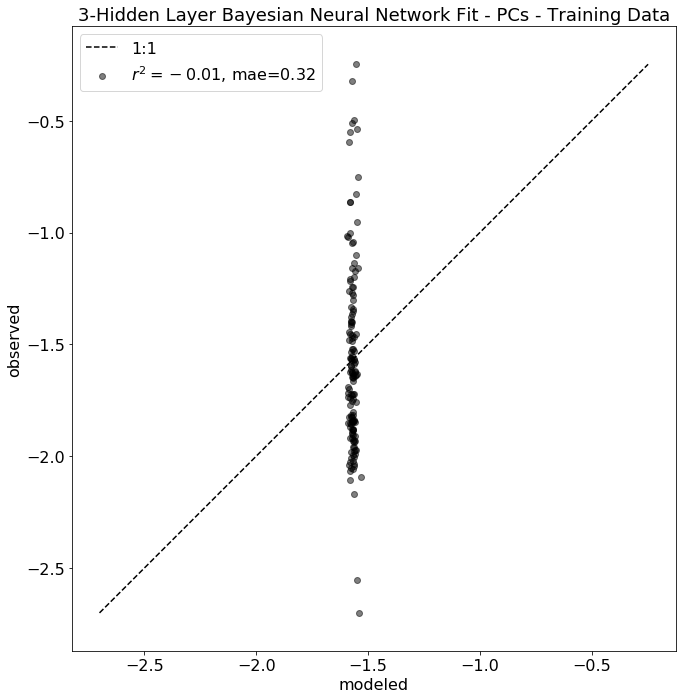

In [227]:
ppc_train_l3h_pc = bnn_l3h_pc.predict(X_pc_shared, likelihood_name='likelihood')
bnn_l3h_pc.plot_model_fits(y_train, ppc_train_l3h_pc, loss_metric='mae',
                       title='3-Hidden Layer Bayesian Neural Network Fit - PCs - Training Data'); 

### Adding SST

In [245]:
X_s_train_pc_sst = X_s_train.loc[:, 'oisst_s':].drop('solz_s', axis=1)
X_s_test_pc_sst = X_s_test.loc[:, 'oisst_s':].drop('solz_s', axis=1)

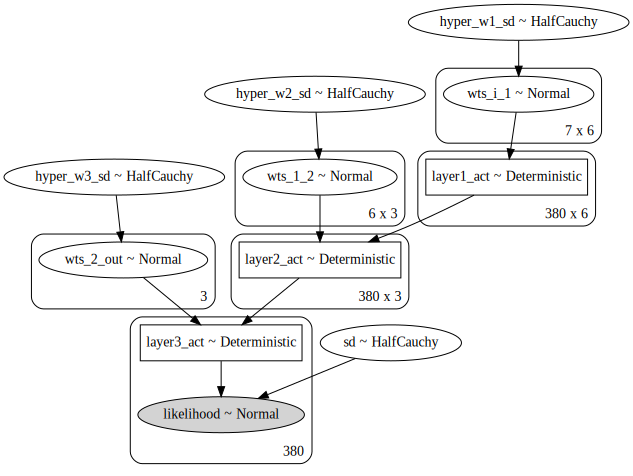

In [253]:
X_pc_sst_shared = shared(X_s_train_pc_sst.values)
bnn_l2h_pc_sst = PyMCModel(bayes_nn_model2_l2_h, X_pc_sst_shared, y_train, model_name='bnnl2',
                         n_hidden1=6, n_hidden2=3, include_bias=False)
bnn_l2h_pc_sst.show_model()

In [ ]:
bnn_l2h_pc_sst.fit_ADVI(n_iter=500000)

Average Loss = 73.586:  30%|██▉       | 147567/500000 [01:28<03:32, 1661.37it/s]

100%|██████████| 2000/2000 [00:02<00:00, 767.70it/s]


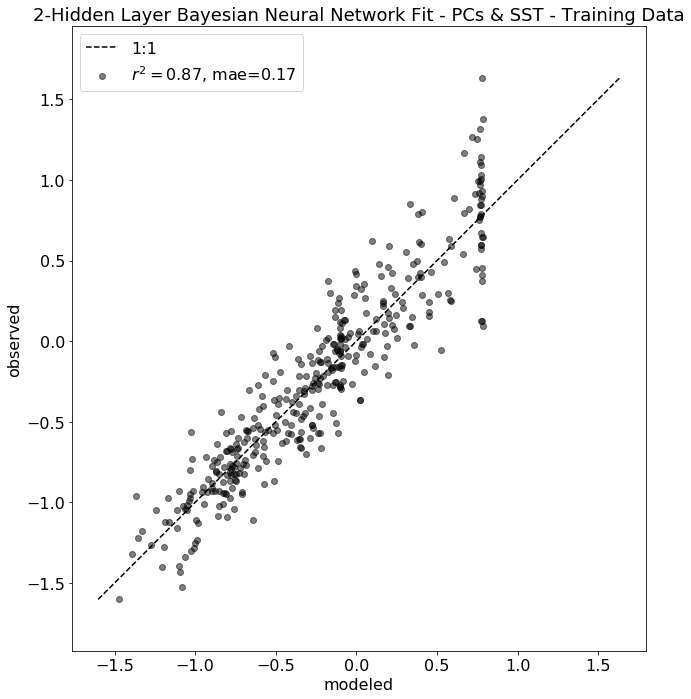

In [252]:
ppc_train_l2h_pc_sst = bnn_l2h_pc_sst.predict(X_pc_sst_shared, likelihood_name='likelihood')
bnn_l2h_pc_sst.plot_model_fits(y_train, ppc_train_l2h_pc_sst, loss_metric='mae',
                       title='2-Hidden Layer Bayesian Neural Network Fit - PCs & SST - Training Data'); 

100%|██████████| 2000/2000 [00:01<00:00, 1079.46it/s]


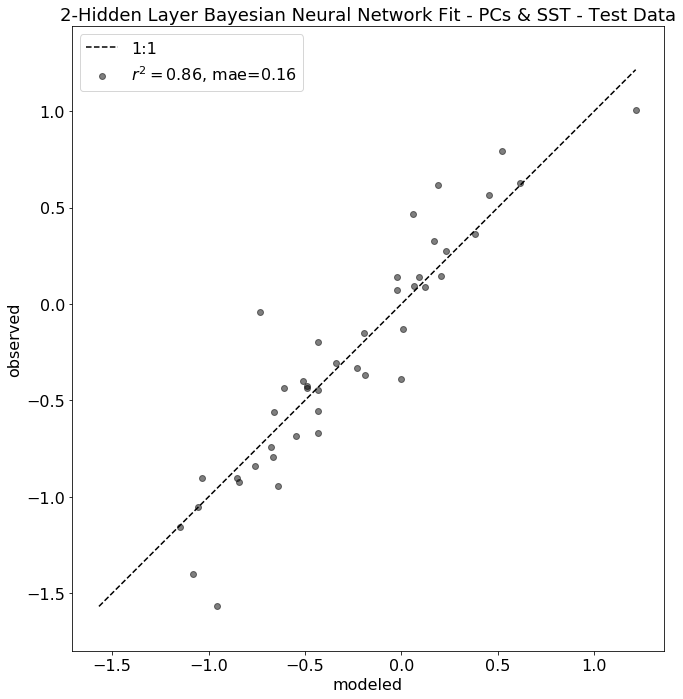

In [230]:
X_pc_sst_shared.set_value(X_s_test_pc_sst)
ppc_test_l2h_pc_sst = bnn_l2h_pc_sst.predict(X_pc_sst_shared, likelihood_name='likelihood')

bnn_l2h_pc_sst.plot_model_fits(y_test, ppc_test_l2h_pc_sst, loss_metric='mae',
                       title='2-Hidden Layer Bayesian Neural Network Fit - PCs & SST - Test Data'); 

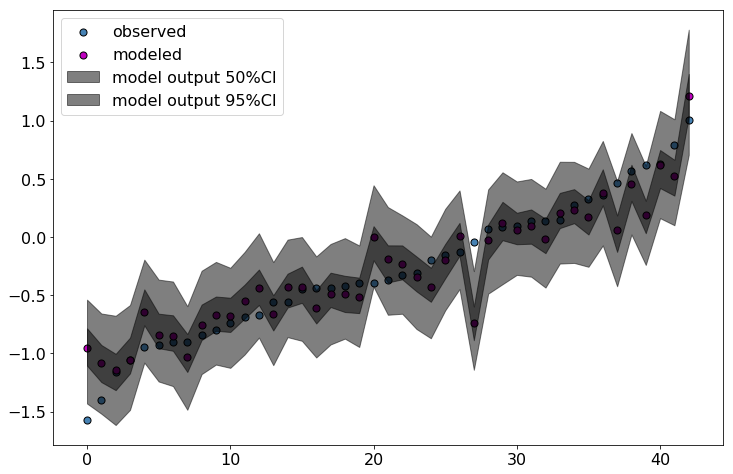

In [232]:
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
lik_mean =ppc_test_l2h_pc_sst.mean(axis=0)
lik_hpd = pm.hpd(ppc_test_l2h_pc_sst)
lik_hpd_05 = pm.hpd(ppc_test_l2h_pc_sst, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
f_fit2.savefig('./figJar/bayesNet/bNN_L2_pc_sst.png', dpi=300, format='png')

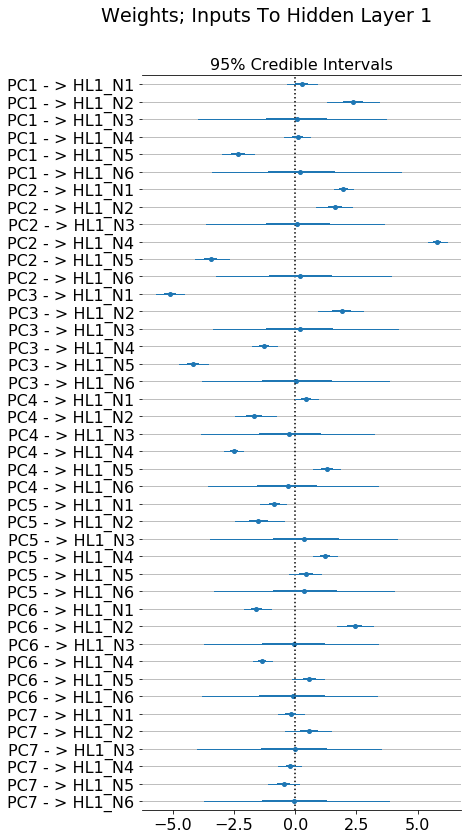

In [233]:
labels = ['PC%d - > HL1_N%d' %(l1n, l2n) for l1n in range(1, 8) for l2n in range(1, 7)]
bnn_l2h_pc_sst.show_forest(['wts_i_1'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(12)
f.suptitle('Weights; Inputs To Hidden Layer 1');

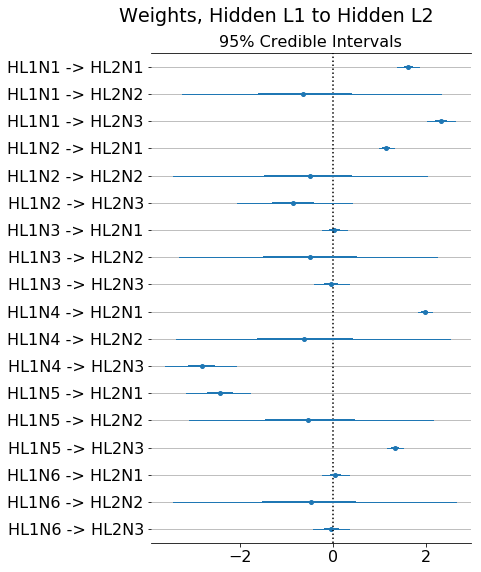

In [234]:
labels = ['HL1N%d -> HL2N%d' %(hl1n, hl2n) for hl1n in range(1, 7) for hl2n in range(1, 4)]

bnn_l2h_pc_sst.show_forest(['wts_1_2'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(8)
f.suptitle('Weights, Hidden L1 to Hidden L2');

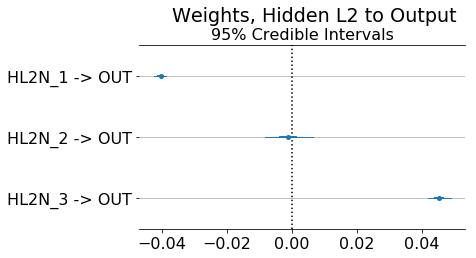

In [235]:
labels = ['HL2N_%d -> OUT' %ni for ni in range(1, 4)]
bnn_l2h_pc_sst.show_forest(['wts_2_out'], feat_labels=labels);
f = pl.gcf()
#ax = pl.gca()
#ax.set_xlim(ax.get_xlim()[0]*2, 0.005)
f.set_figheight(3)
f.suptitle('Weights, Hidden L2 to Output', x=0.6, y=1.08);